In [1]:
import pandas as pd
from scipy.stats import shapiro, levene, ttest_ind, f_oneway
import chardet
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import numpy as np

In [3]:
data_path = "../../German.csv"

# Phát hiện mã hóa
with open(data_path, 'rb') as f:
    result = chardet.detect(f.read())

# Đọc file với mã hóa được phát hiện
df = pd.read_csv(data_path, encoding=result['encoding'])

# Hiển thị 5 dòng đầu tiên
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))

# Hiển thị thông tin các cột
print(df.info())

# Tách dữ liệu thành 2 nhóm
group1 = df[df['Group'] == 'Treatment']['Change']
group2 = df[df['Group'] == 'Control']['Change']

| ID   | Pre   | Retain   | Group     | Gender   | Change   |
|:-----|:------|:---------|:----------|:---------|:---------|
| 101  | 56.41 | 89.19    | Treatment | Male     | 32.78    |
| 103  | 66.67 | 86.49    | Treatment | Male     | 19.82    |
| 105  | 58.97 | 56.76    | Treatment | Male     | -2.21    |
| 107  | 79.49 | 62.16    | Treatment | Male     | -17.33   |
| 110  | 46.15 | 56.76    | Treatment | Male     | 10.61    |
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      28 non-null     int64  
 1   Pre     28 non-null     float64
 2   Retain  28 non-null     float64
 3   Group   28 non-null     object 
 4   Gender  28 non-null     object 
 5   Change  28 non-null     float64
dtypes: float64(3), int64(1), object(2)
memory usage: 1.4+ KB
None


In [4]:
# Kiểm tra tính phân phối chuẩn (Shapiro-Wilk test)
print("Kiểm định Shapiro-Wilk cho tính phân phối chuẩn:")
for group_name, group_data in zip(["Treatment", "Control"], [group1, group2]):
    stat, p_value = stats.shapiro(group_data)
    print(f"- {group_name}: Statistic = {stat:.3f}, p-value = {p_value:.4f}")

Kiểm định Shapiro-Wilk cho tính phân phối chuẩn:
- Treatment: Statistic = 0.966, p-value = 0.7902
- Control: Statistic = 0.934, p-value = 0.3875


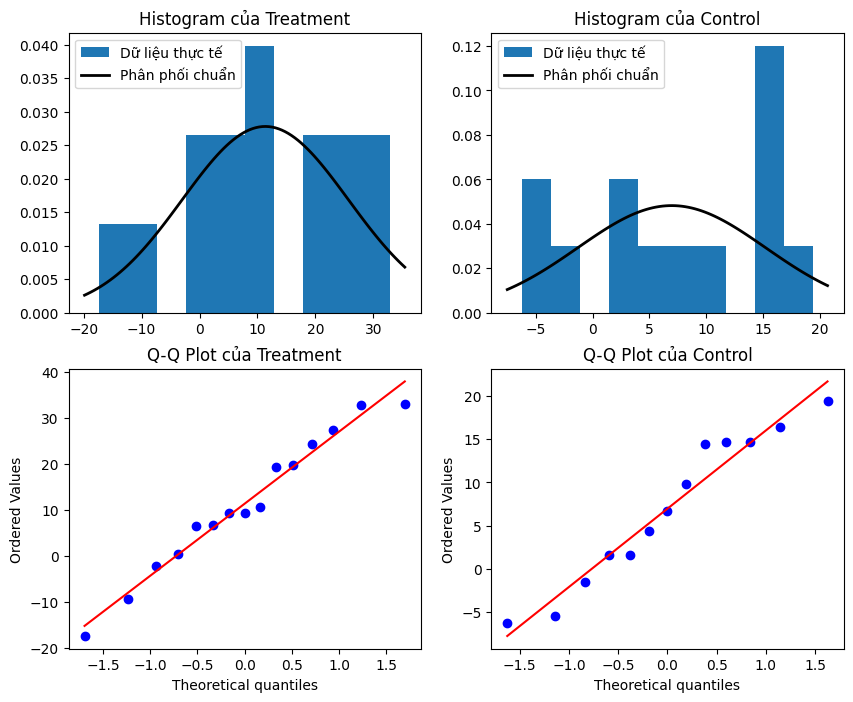

In [5]:
# Vẽ Histogram và Q-Q plot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, (group_name, group_data) in enumerate(zip(["Treatment", "Control"], [group1, group2])):
    # Vẽ histogram
    axs[0, i].hist(group_data, density=True, label="Dữ liệu thực tế")
    axs[0, i].set_title(f"Histogram của {group_name}")

    # Tạo đường phân phối chuẩn lý thuyết
    mean, std_dev = stats.norm.fit(group_data)
    xmin, xmax = axs[0, i].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mean, std_dev)
    axs[0, i].plot(x, p, 'k', linewidth=2, label="Phân phối chuẩn")

    # Thêm legend
    axs[0, i].legend()

    # Vẽ Q-Q plot
    stats.probplot(group_data, plot=axs[1, i])
    axs[1, i].set_title(f"Q-Q Plot của {group_name}")
    # Lưu biểu đồ
    axs[0, i].get_figure().savefig(f"histogram_{group_name}.png")
    axs[1, i].get_figure().savefig(f"qq_plot_{group_name}.png")
plt.show()

In [7]:
# Kiểm định phương sai bằng nhau (Levene's test) - Phương bản tốt hơn F-Test
stat, p_value = stats.levene(group1, group2)
print(f"\nKiểm định Levene: Statistic={stat:.3f}, p-value={p_value:.4f}")

if p_value <= 0.05:
    print("Có bằng chứng để bác bỏ giả thuyết null: Phương sai không bằng nhau.")
else:
    print("Không đủ bằng chứng để bác bỏ giả thuyết null: Phương sai có thể bằng nhau.")


# Kiểm định t
if p_value > 0.05:  # Phương sai bằng nhau (Pooled t-test)
    t_statistic, p_value = stats.ttest_ind(group1, group2)
    print(f"Pooled t-test: Statistic={t_statistic:.3f}, p-value={p_value:.4f}")
else:  # Phương sai không bằng nhau (Satterthwaite t-test)
    t_statistic, p_value = stats.ttest_ind(group1, group2, equal_var=False)
    print(f"Satterthwaite t-test: Statistic={t_statistic:.3f}, p_value={p_value:.4f}")

if p_value <= 0.05:
    print("Có bằng chứng để bác bỏ giả thuyết null: trung bình không bằng nhau.")
else:
    print("Không đủ bằng chứng để bác bỏ giả thuyết null: trung bình có thể bằng nhau.")

# Thống kê mô tả
print("\nThống kê mô tả:")
print(df.groupby('Group')['Change'].describe())


Kiểm định Levene: Statistic=2.385, p-value=0.1346
Không đủ bằng chứng để bác bỏ giả thuyết null: Phương sai có thể bằng nhau.
Pooled t-test: Statistic=0.937, p-value=0.3576
Không đủ bằng chứng để bác bỏ giả thuyết null: trung bình có thể bằng nhau.

Thống kê mô tả:
           count       mean        std    min   25%   50%    75%    max
Group                                                                  
Control     13.0   6.967692   8.616632  -6.24  1.59  6.72  14.70  19.41
Treatment   15.0  11.358667  14.853523 -17.33  3.47  9.29  22.11  32.92
